# pySCENIC protocol: PBMC10k **(polished-custom)**

September 2019

Dataset: *10k PBMCs from a Healthy Donor* available from 10x Genomics ([here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3)).

**Note: This the polished-custom version is based on the instructions laid out in the original paper:
https://www.nature.com/articles/s41596-020-0336-2**

Also see this for scanpy tutorials: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

## 1. Import files and dependencies

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import pickle as pk
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
from IPython.core.debugger import set_trace

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/home/jovyan/work/dask_k8s/PBMC_project/work_dir"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "intermediate/pbmc10k_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "intermediate/PBMC10k_filtered.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "intermediate/anndata.h5ad"
f_anndata_path_integrated = "intermediate/anndata_integrated.h5ad"

# path to pyscenic output
f_pyscenic_output = "intermediate/pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'intermediate/pbmc10k_scenic_integrated-output.loom'

#Path to float32 pickle expression matrix
ex_matrix_path = 'intermediate/pbmc10k_filtered_scenic.pkl'

#Path to final int64 pickle expression matrix
ex_matrix_path_final = 'intermediate/pbmc10k_filtered_scenic_final.pkl'

#Adjacencies pickle file
f_adj_pickle = "intermediate/adjacencies.pkl"

#Adjacencies csv file
f_adj_csv = "intermediate/adjacencies.csv"

#Modules pickle file
f_modules_output = 'intermediate/modules.pk'

#Motifs csv file
f_motifs_csv = "intermediate/motifs_old_rkdb.csv"

#Regulons pickle file
f_regulons_pickle = "intermediate/regulons_old_rkdb.pkl"

#AUC mtx file (CSV)
f_auccell_mtx_csv = "intermediate/auc_old_rkdb.csv"

#AUC mtx file (pickle)
f_auccell_mtx_pickle = "intermediate/auc_old_rkdb.pkl"

#AUCELL cluster graph
f_aucell_cluster = "graphs/auc_cluster.png"

# transcription factors list
f_tfs = "/home/jovyan/work/dask_k8s/PBMC_project/work_dir/input/hs_hgnc_tfs.txt" # human

#Motif annotations
MOTIF_ANNOTATIONS_FNAME = 'input/motifs-v9-nr.hgnc-m0.001-o0.0.tbl'

In [3]:
#Retrieving the databases path
DATABASE_FOLDER = os.environ['DATABASES_PATH']
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "PBMC/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather")

In [11]:
#Dask scheduler DNS name and port through environmental variables
dask_scheduler_name = "myrelease-dask-scheduler:8786"
dask_scheduler_IP = os.environ['MYRELEASE_DASK_SCHEDULER_PORT_8786_TCP_ADDR']+":"+os.environ['MYRELEASE_DASK_SCHEDULER_SERVICE_PORT_MYRELEASE_DASK_SCHEDULER']

In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.8.0
scanpy      1.9.3
-----
MulticoreTSNE       NA
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.0
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.1.0
dateutil            2.8.2
debugpy             1.6.5
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.8.0
hypergeom_ufunc     NA
igraph              0.10.4
importlib_resources NA
invgauss_ufunc      NA
ipykernel           6.20.1
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
jupyter_server      2.1.0
kiwisolver          1.4.4
llvmlite            0.39.1
loompy              3.0.7
louvain             0.8.0
lz4                 4.2.0
markup

In [6]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 7

#### Connecting to Dask scheduler

In [7]:
from dask.distributed import Client, progress
c = Client()
c

<Client: 'tcp://10.42.5.108:8786' processes=8 threads=8, memory=44.70 GiB>

## 2. Expression data import
There are several ways to import expression data. For simplicity we focus on getting the data into a Scanpy anndata object or a loom file.  Scanpy provides functions for reading in a wide variety of formats (described [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html#reading)).

### Reading in expression data: 10x Genomics mtx files
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.

In [8]:
f_mtx_dir = '/home/jovyan/work/dask_k8s/PBMC_project/work_dir/input/filtered_feature_bc_matrix/'

adata = sc.read_10x_mtx(
    f_mtx_dir ,                 # the directory with the `.mtx` file
    var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
    cache=True) 



... reading from cache file cache/home-jovyan-work-dask_k8s-PBMC_project-work_dir-input-filtered_feature_bc_matrix-matrix.h5ad


In [9]:
#Checking data
adata

AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types'

In [10]:
#Note: This command is only present in the publication
adata.var_names_make_unique()

### Saving to an un-filtered loom file

In [11]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

## 3. Further pre-processing of expression data

### a. Cleaning and quality control

In [12]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [13]:
#Determining counts per gene and cells per gene 
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


In [14]:
#Getting the pyscenic thresholds (what thresholds???)
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  353.07
minSamples:  117.69


#### ***Article's steps start here***

In [15]:
# compute the number of genes per cell (computes ‘n_genes' column) 
sc.pp.filter_cells(adata, min_genes=0)

In [16]:
# mito and genes/counts cuts 
mito_genes = adata.var_names.str.startswith('MT-')

In [17]:
# for each cell compute fraction of counts in mito genes vs. all genes 
adata.obs['percent_mito'] = np.ravel(np.sum( adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))

In [18]:
# add the total counts per cell as observations-annotation to adata 
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

### b. Diagnostic plots, pre-filtering

#### Number of genes expressed per cell

/tmp/ipykernel_911/1413385581.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
/tmp/ipykernel_911/1413385581.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
/tmp/ipykernel_911/1413385581.py:10: UserWarning: 

`d

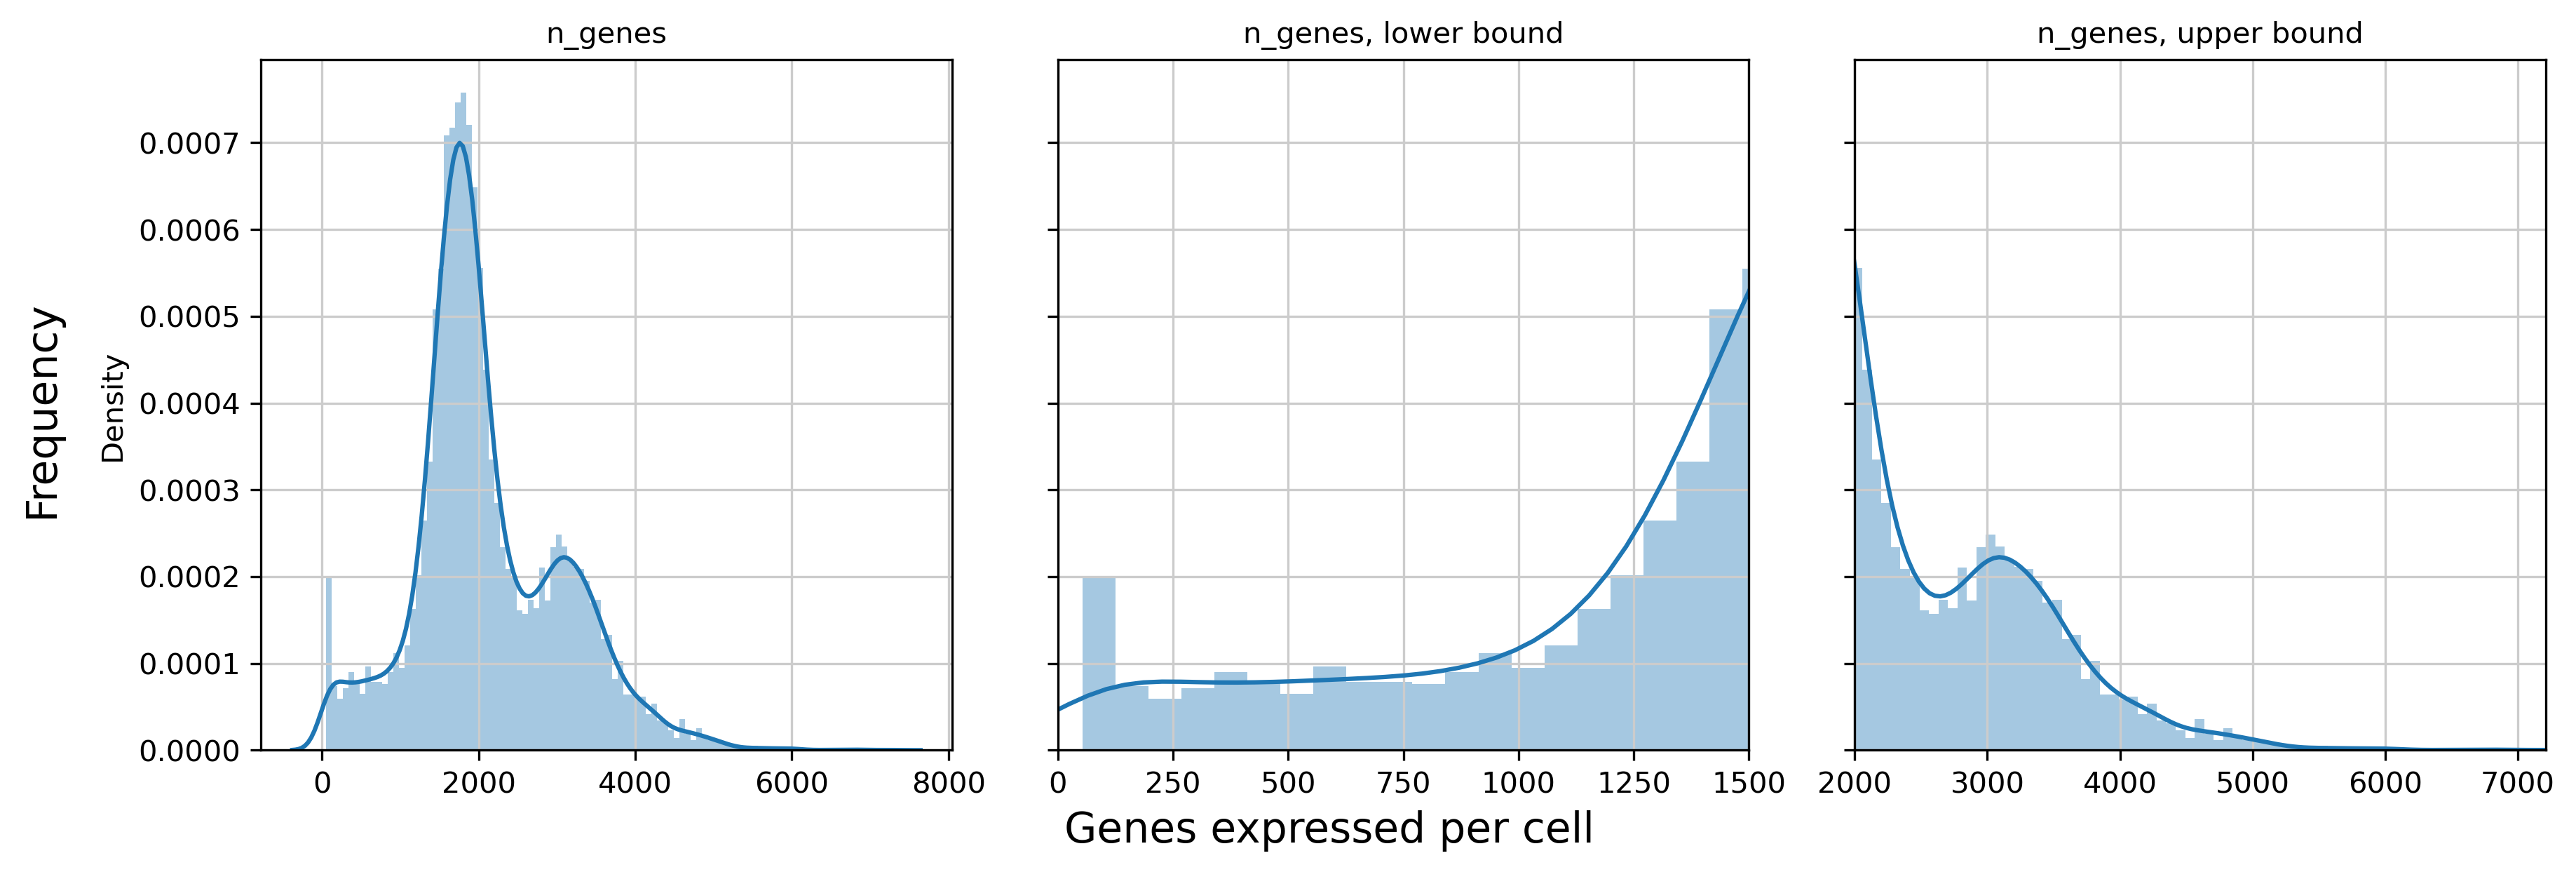

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Percentage of mitochondrial reads per cell

/tmp/ipykernel_911/1055941436.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
/tmp/ipykernel_911/1055941436.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
/tmp/ipykernel

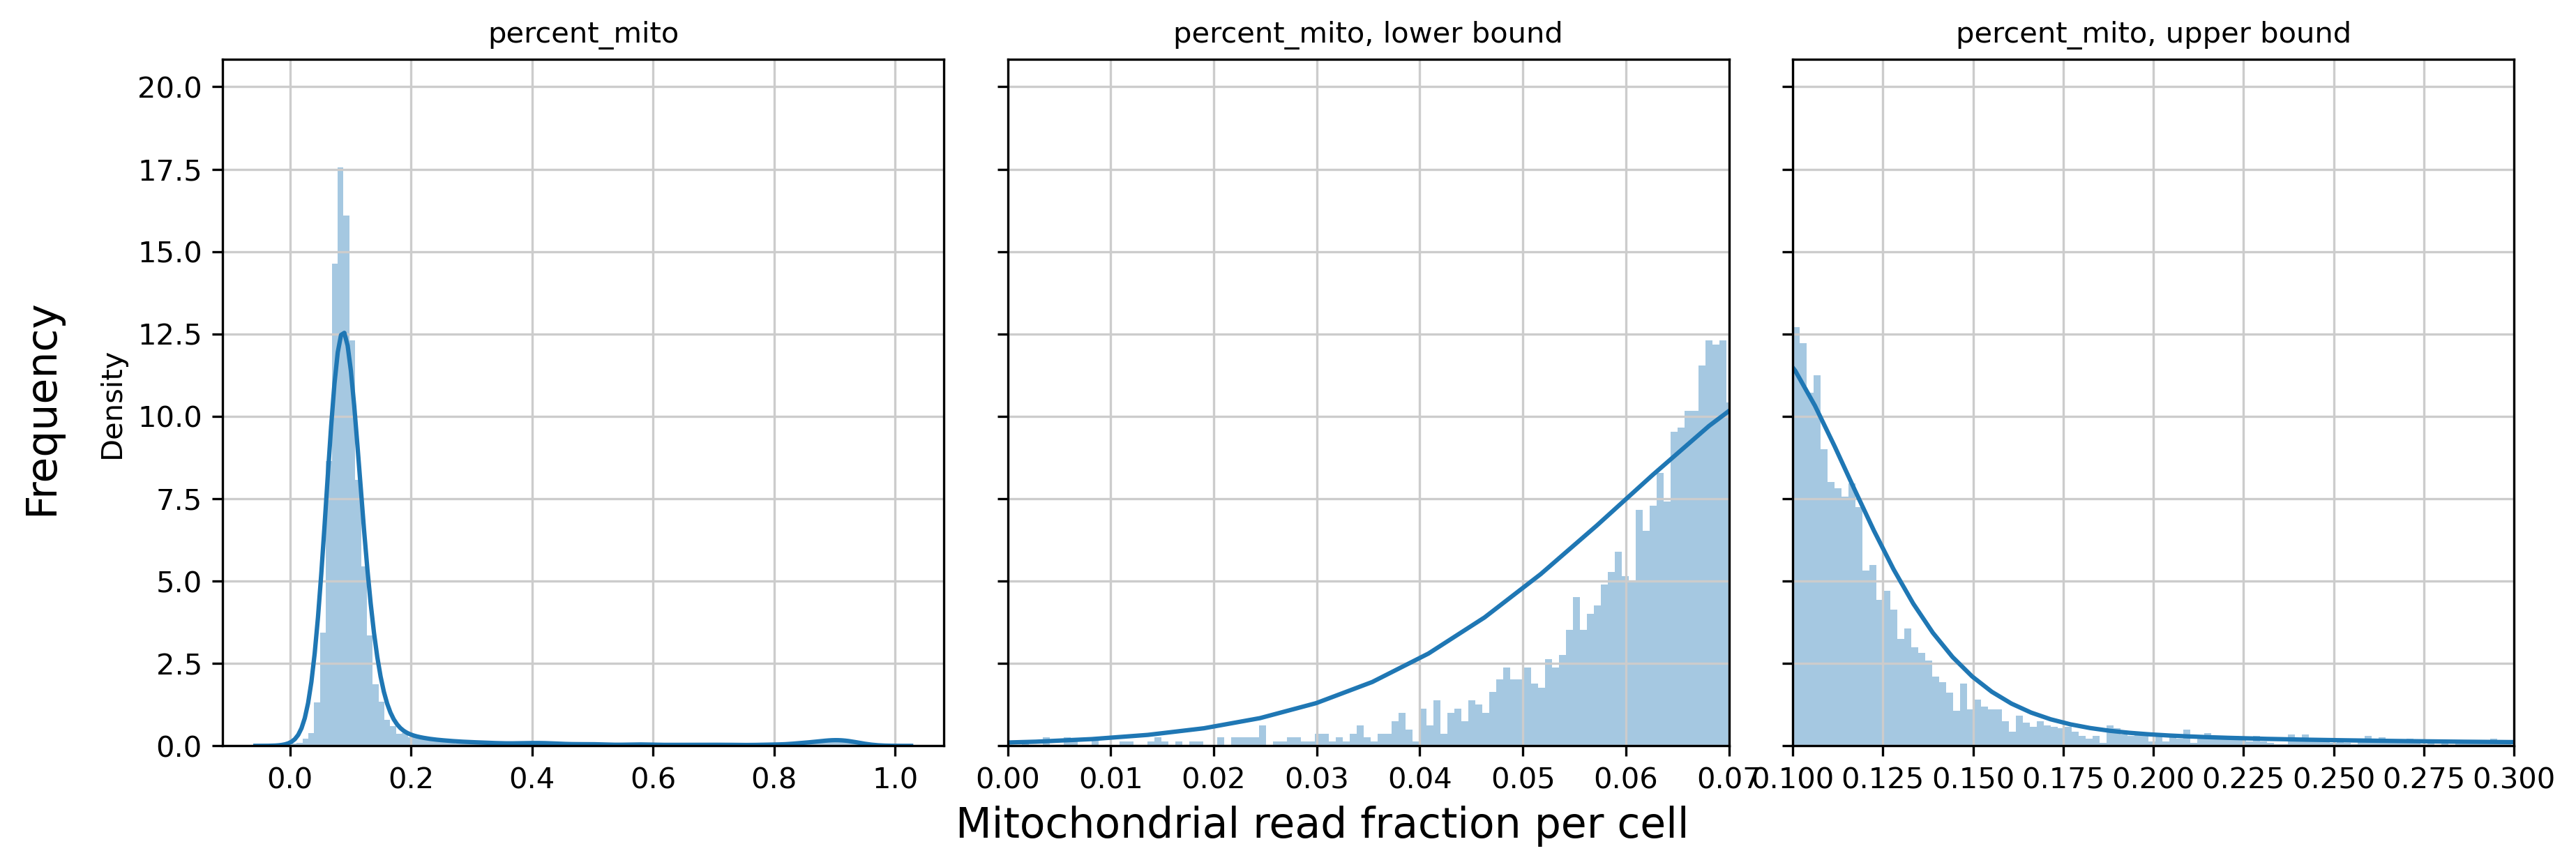

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Three-panel summary plots

/tmp/ipykernel_911/3363066550.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
/tmp/ipykernel_911/3363066550.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
/tmp/ipykernel_91

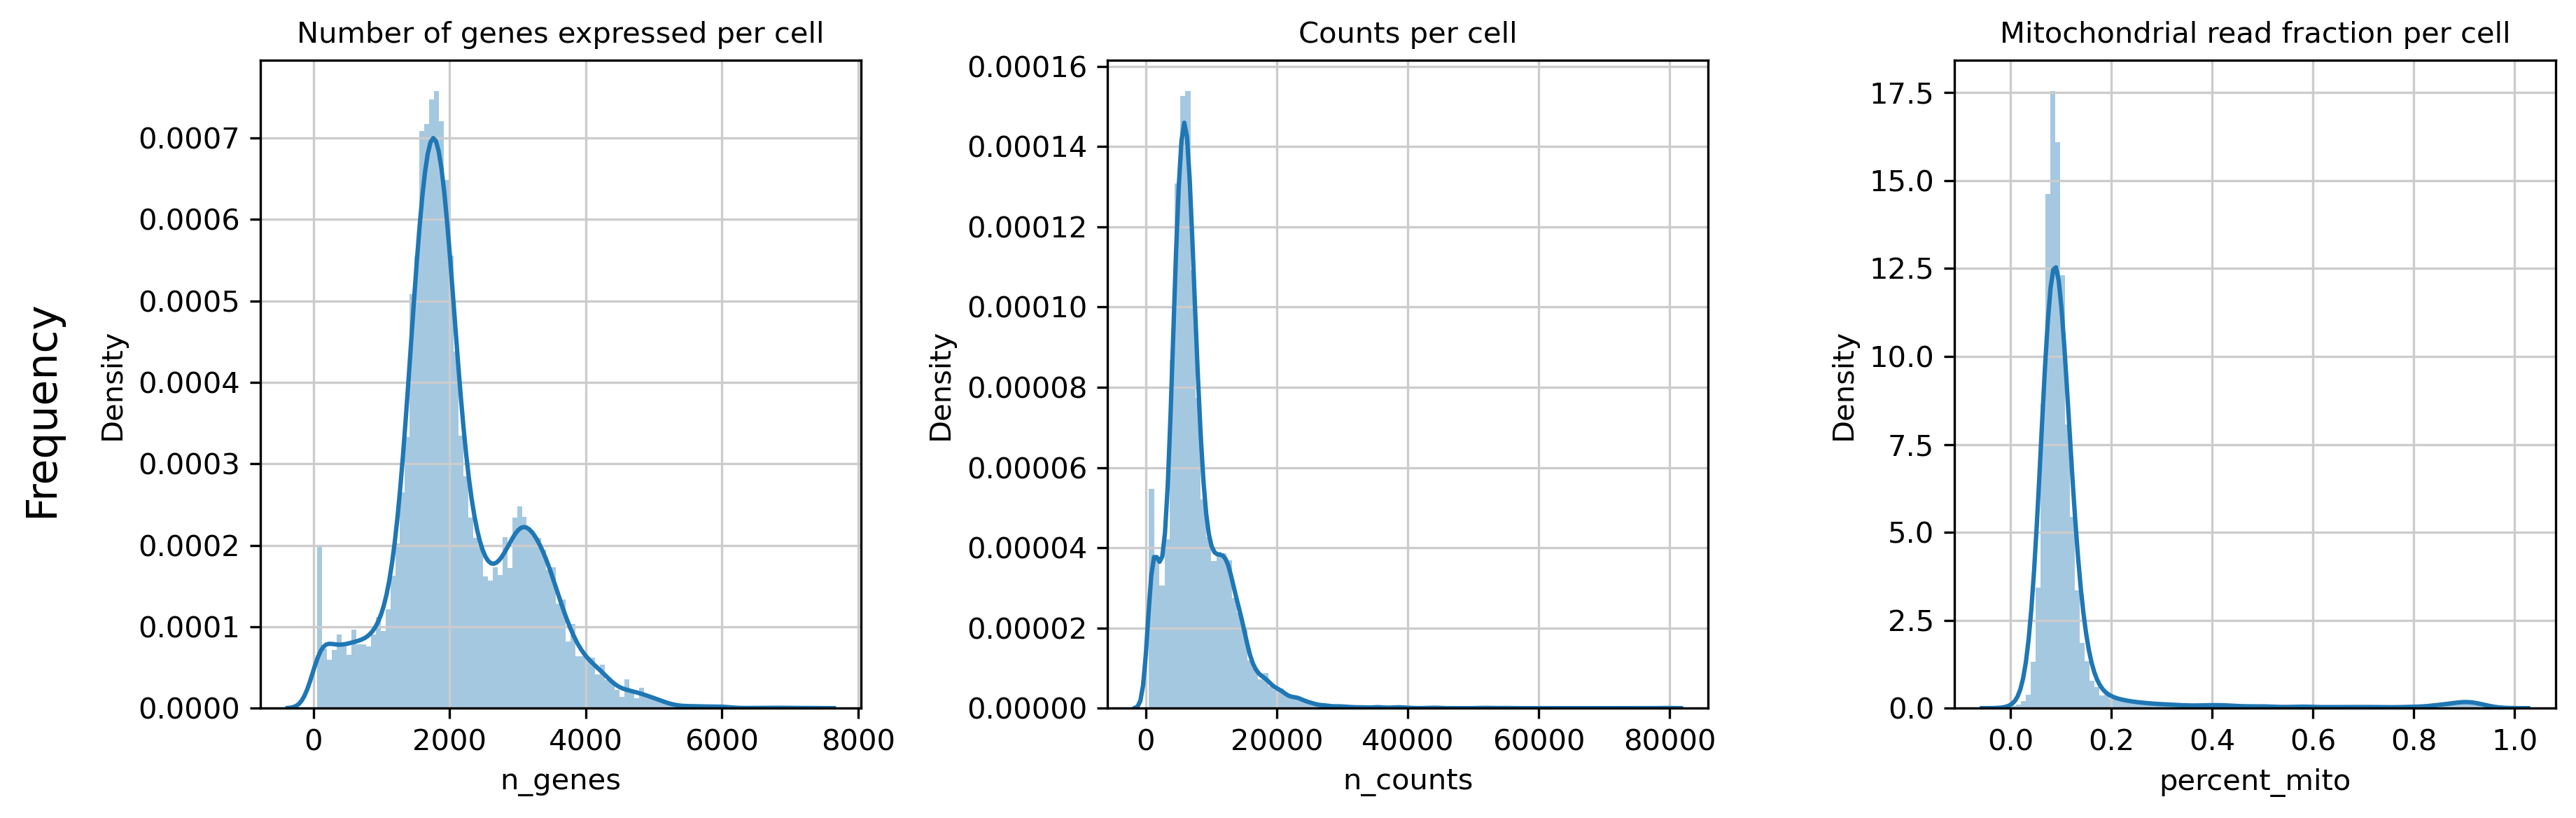

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

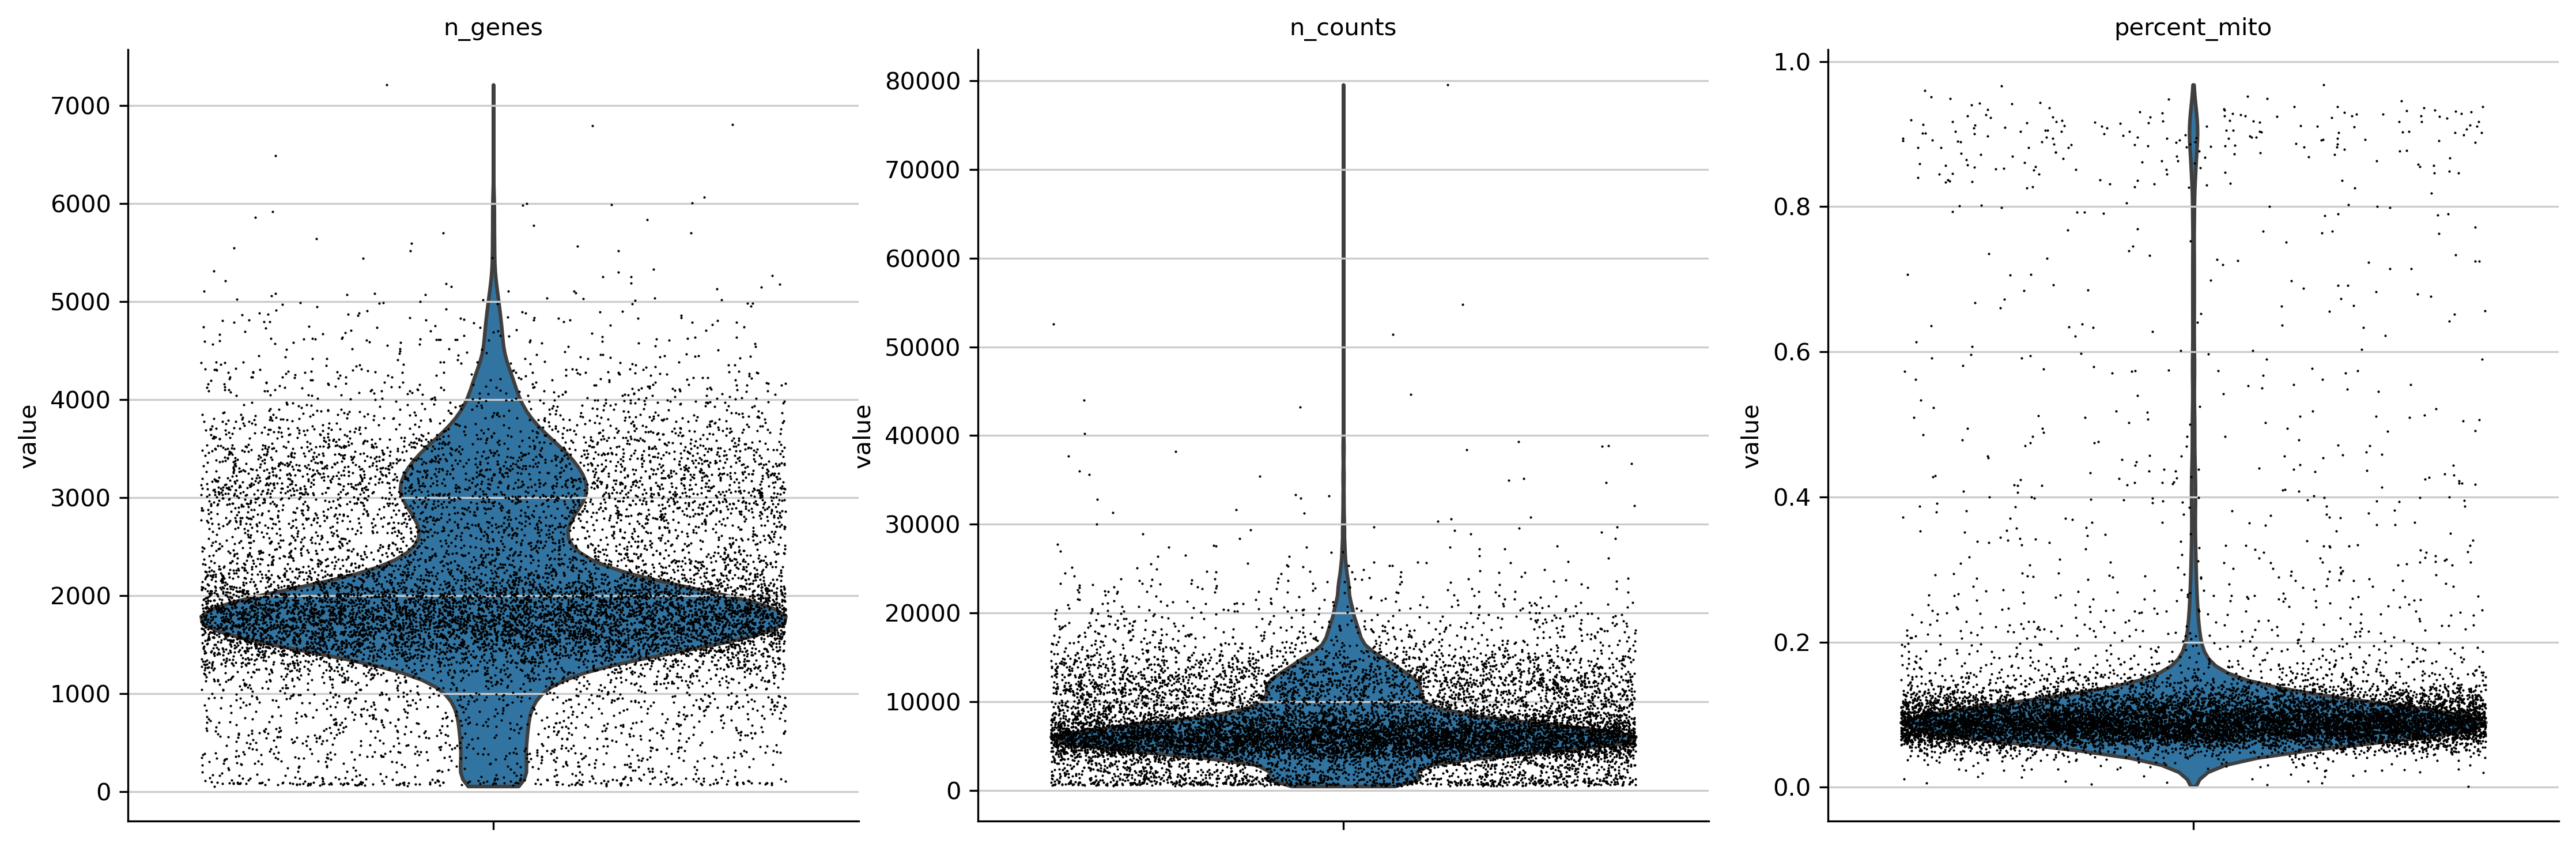

In [22]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

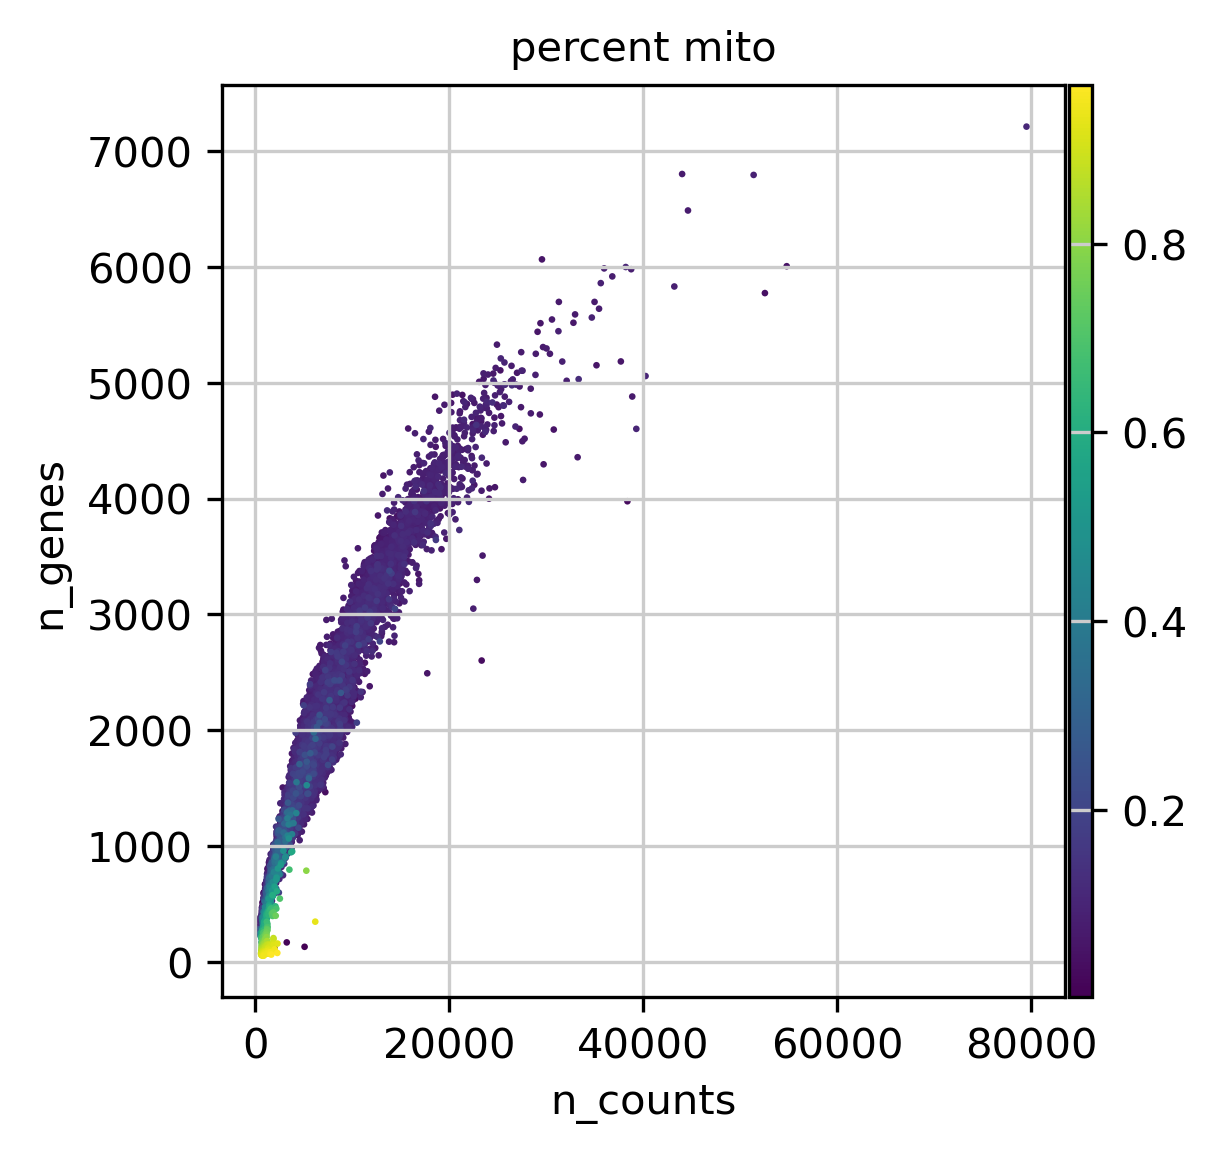

In [23]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### c. Filtering steps with basic thresholds

In [24]:
#Minimum number of genes for each cell
sc.pp.filter_cells(adata, min_genes=200)

filtered out 232 cells that have less than 200 genes expressed


In [25]:
#Minimum number of genes for each cell
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13246 genes that are detected in less than 3 cells


In [26]:
#Setting max number of genes
adata = adata[adata.obs['n_genes'] < 4000, :]

In [27]:
#Setting quality control threshold
adata = adata[adata.obs['percent_mito'] < 0.15, :]

## 4. Post-filtering plots
**Optional**

#### Three-panel summary plots

/tmp/ipykernel_911/4135359199.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
/tmp/ipykernel_911/4135359199.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
/tmp/ipykernel_91

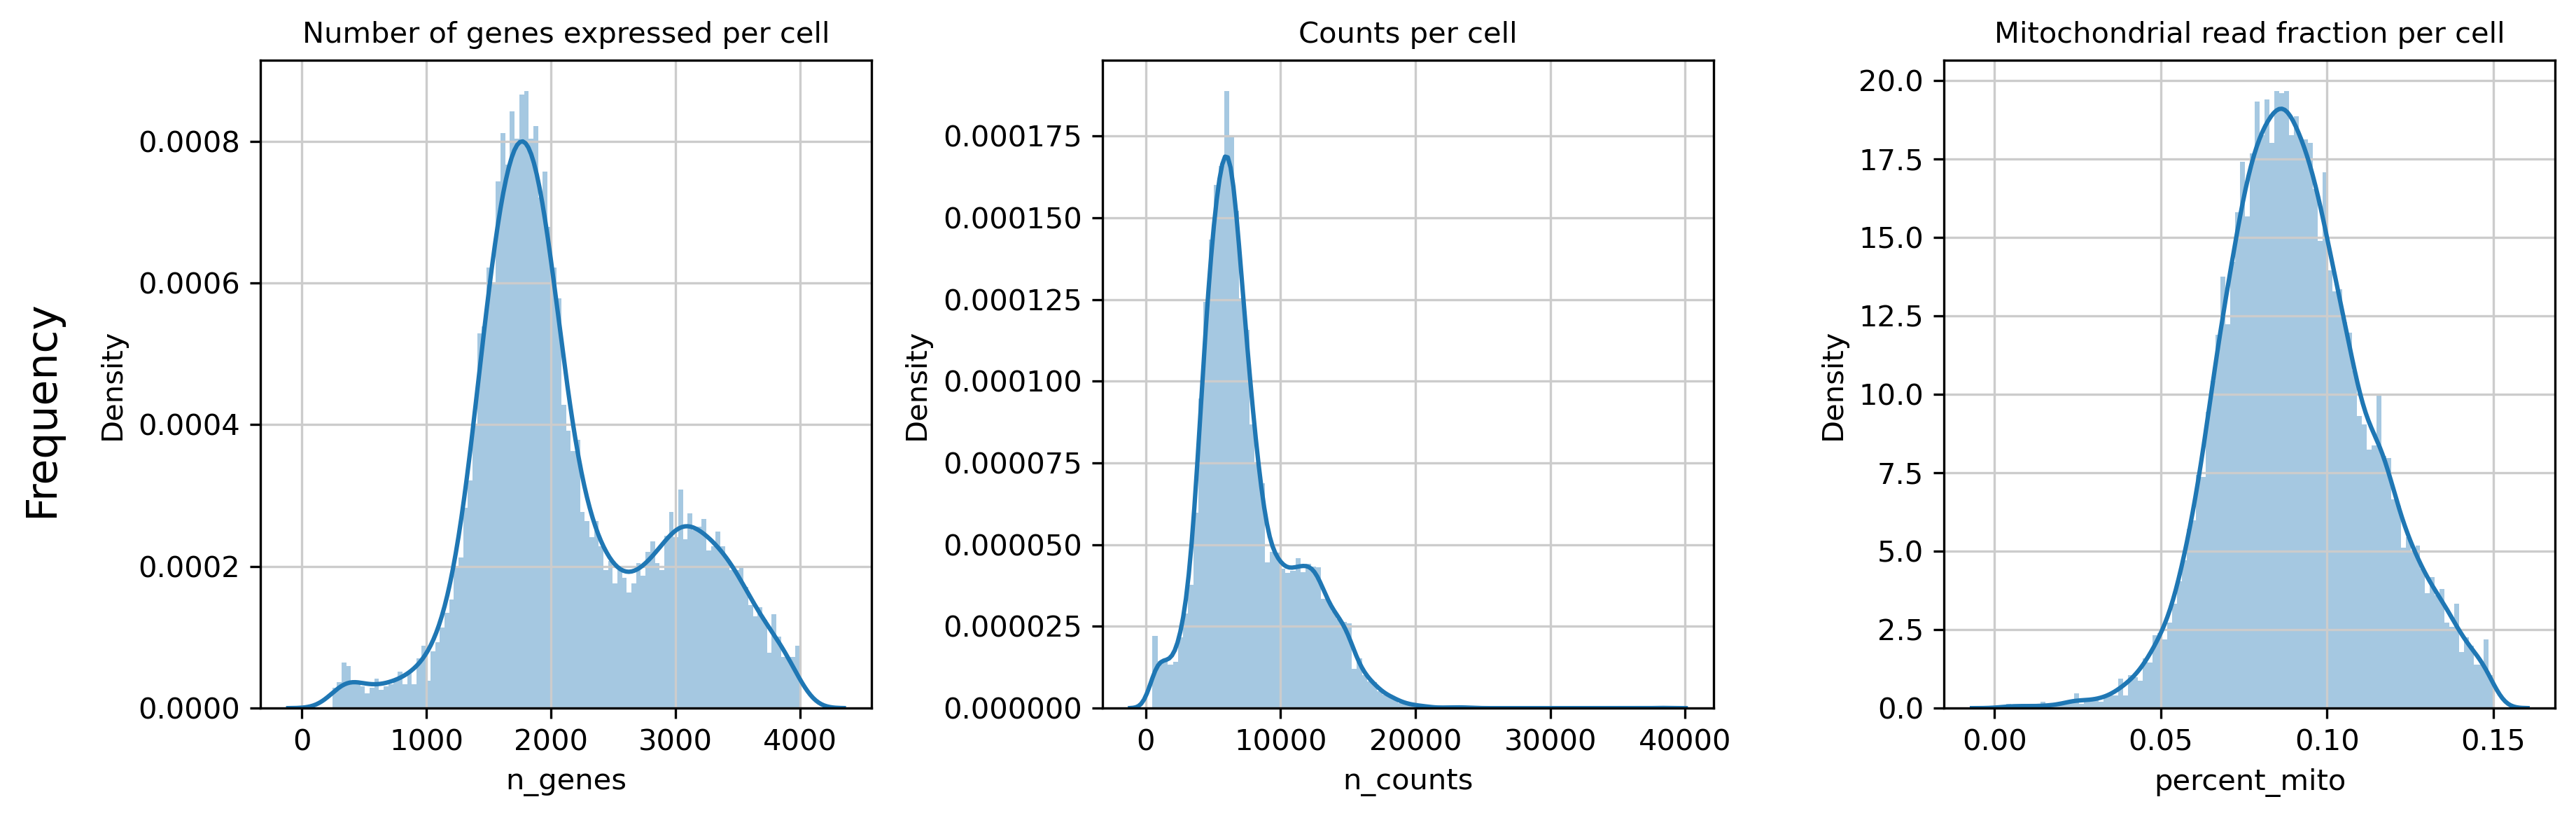

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

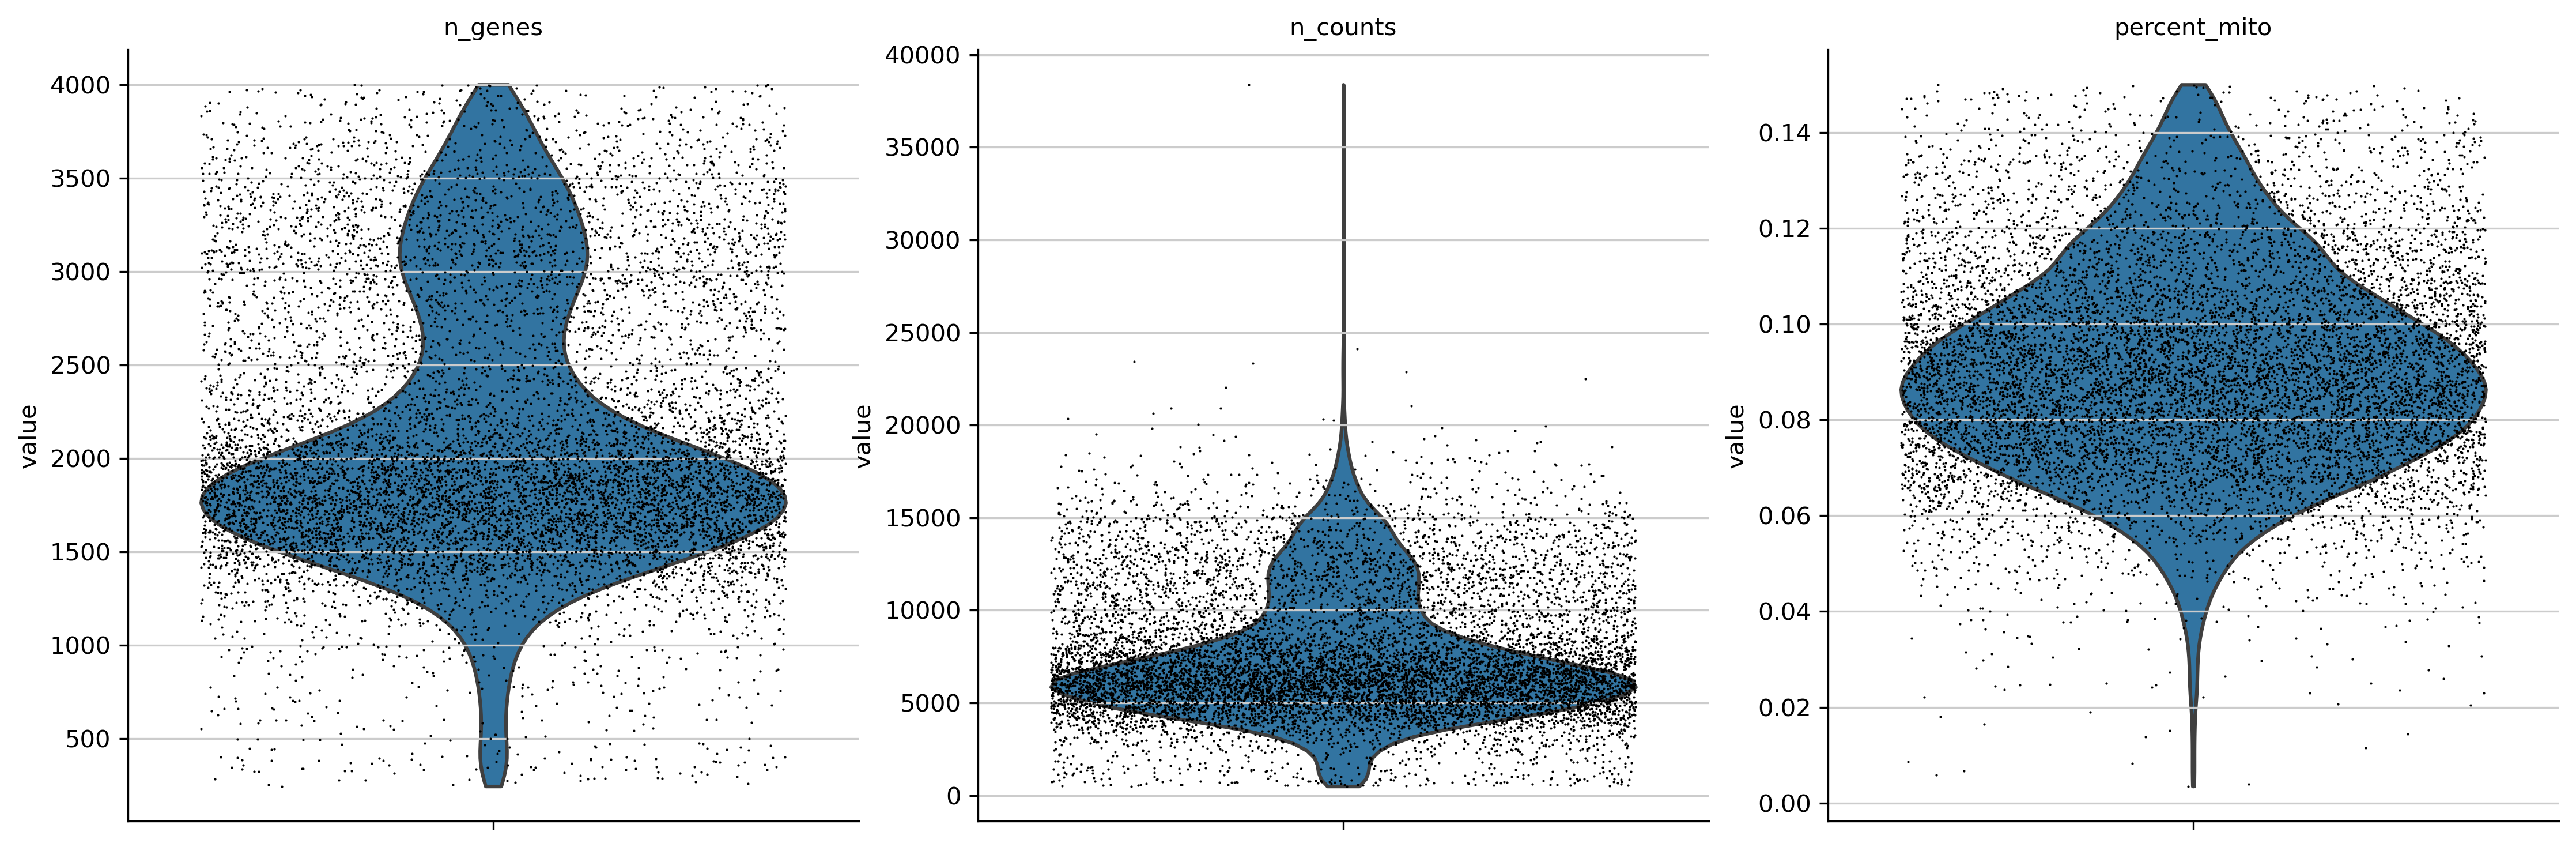

In [29]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

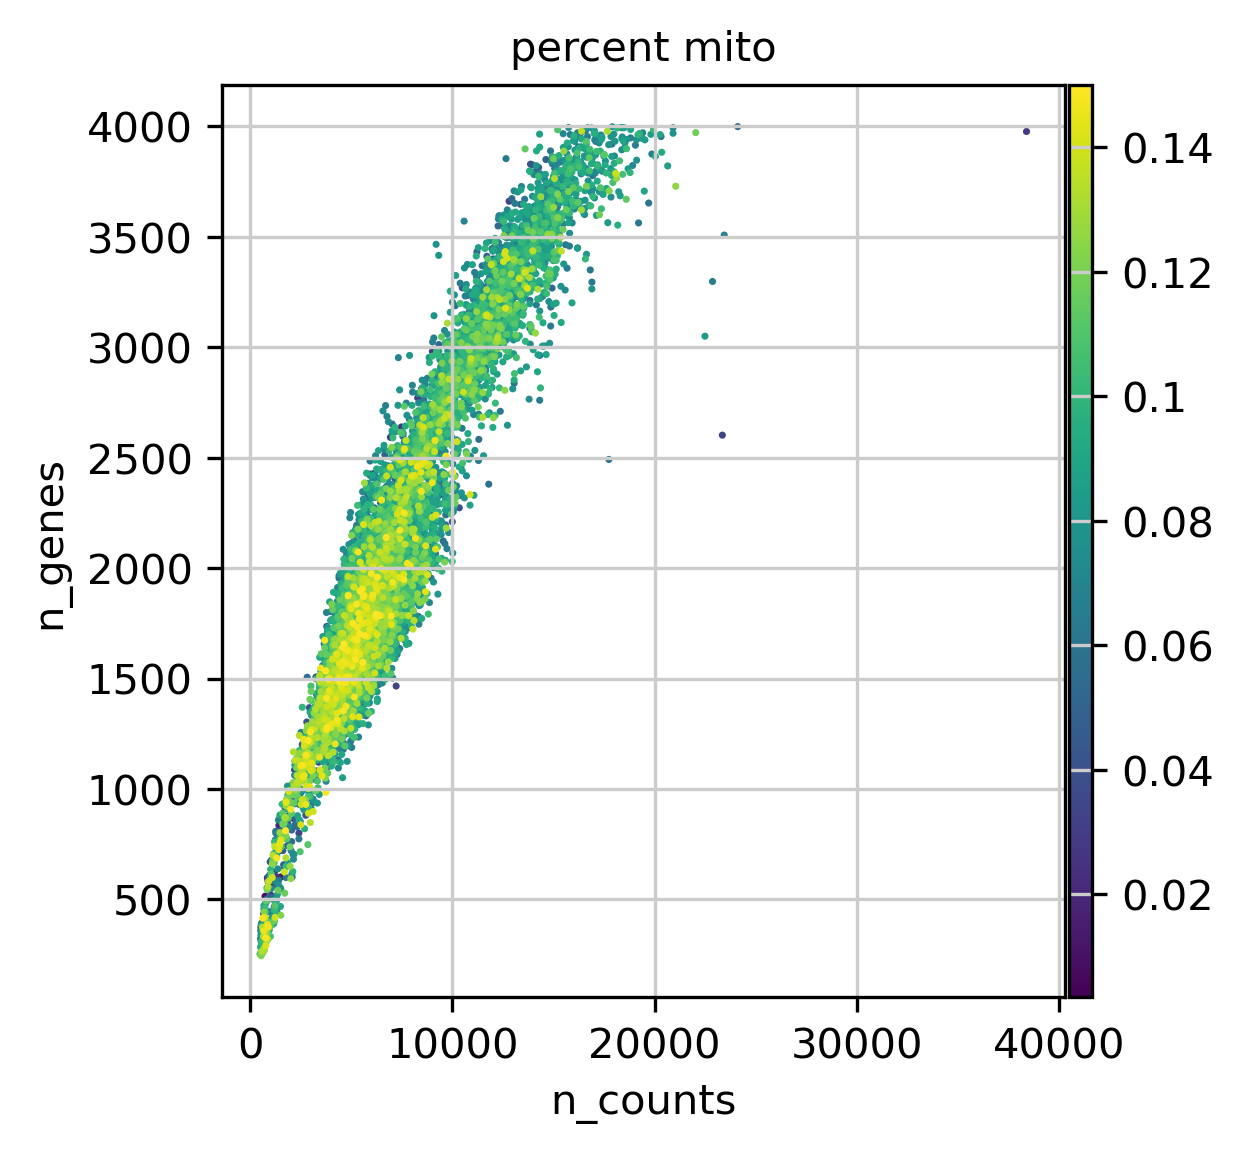

In [30]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

## 5. pySCENIC preparation

### A. **Writing** the ada file
Update the anndata file, to be used for further processing, clustering, visualization, etc..

In [31]:
#Checking the adata file
adata

View of AnnData object with n_obs × n_vars = 10280 × 20292
    obs: 'nGene', 'nUMI', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [32]:
#Update the anndata file, to be used for further processing, clustering, visualization, etc..
adata.write( f_anndata_path )

### B. Creating a loom file

Output the basic filtered expression matrix to a loom file.  

This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [33]:
import loompy as lp
row_attrs = { 
    "Gene": np.array(adata.var_names),             
} 

col_attrs = { 
    "CellID": np.array(adata.obs_names), "nGene": np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten(), "nUMI": np.array(np.sum(adata.X.transpose(),axis=0)).flatten(), 
} 

lp.create(f_loom_path_scenic,adata.X.transpose(),row_attrs, col_attrs)

### C. recovering the matrix

#### Obtaining the dataframe

In [34]:
#Obtaining matrix dataframe
ex_matrix = adata.to_df()

In [35]:
#Checking matrix info
ex_matrix.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 10280 entries, AAACCCAAGCGCCCAT-1 to TTTGTTGTCTTACTGT-1
Columns: 20292 entries, AL627309.1 to AC240274.1
dtypes: float32(20292)
memory usage: 797.1 MB


In [36]:
#Checking for NaN
ex_matrix.isnull().values.any()

False

In [37]:
#Counting NaN
ex_matrix.isnull().sum().sum()

0

In [39]:
#Saving matrix as a pickle
ex_matrix.to_pickle(ex_matrix_path)

#### Converting the dtype

In [40]:
#Finding the dtypes
display(ex_matrix.dtypes)

Gene
AL627309.1    float32
AL627309.3    float32
AL669831.5    float32
FAM87B        float32
LINC00115     float32
               ...   
AC011043.1    float32
AL592183.1    float32
AC007325.4    float32
AL354822.1    float32
AC240274.1    float32
Length: 20292, dtype: object

In [41]:
#Finding what the column consists of
ex_matrix.dtypes.values[0]

dtype('float32')

In [42]:
#Checking if effectively all column dtypes are "float32"
ex_matrix.dtypes.where(lambda x : x!=np.float32).dropna()

Series([], dtype: object)

In [44]:
#Changing all dtypes to int64
ex_matrix_int = ex_matrix.astype(int)

In [45]:
#Checking the dataframe
ex_matrix_int.shape

(10280, 20292)

In [46]:
#Saving the final int64_matrix as a pickle
ex_matrix_int.to_pickle(ex_matrix_path_final)

## 5. Further pre-processing of expression data
**Note: This procedure is necessary for the final integration steps (it runs in parallel to the SCENIC pipeline for now)**

### Re-load adata

In [47]:
#Recovering the adata file
adata = sc.read_h5ad( f_anndata_path )

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


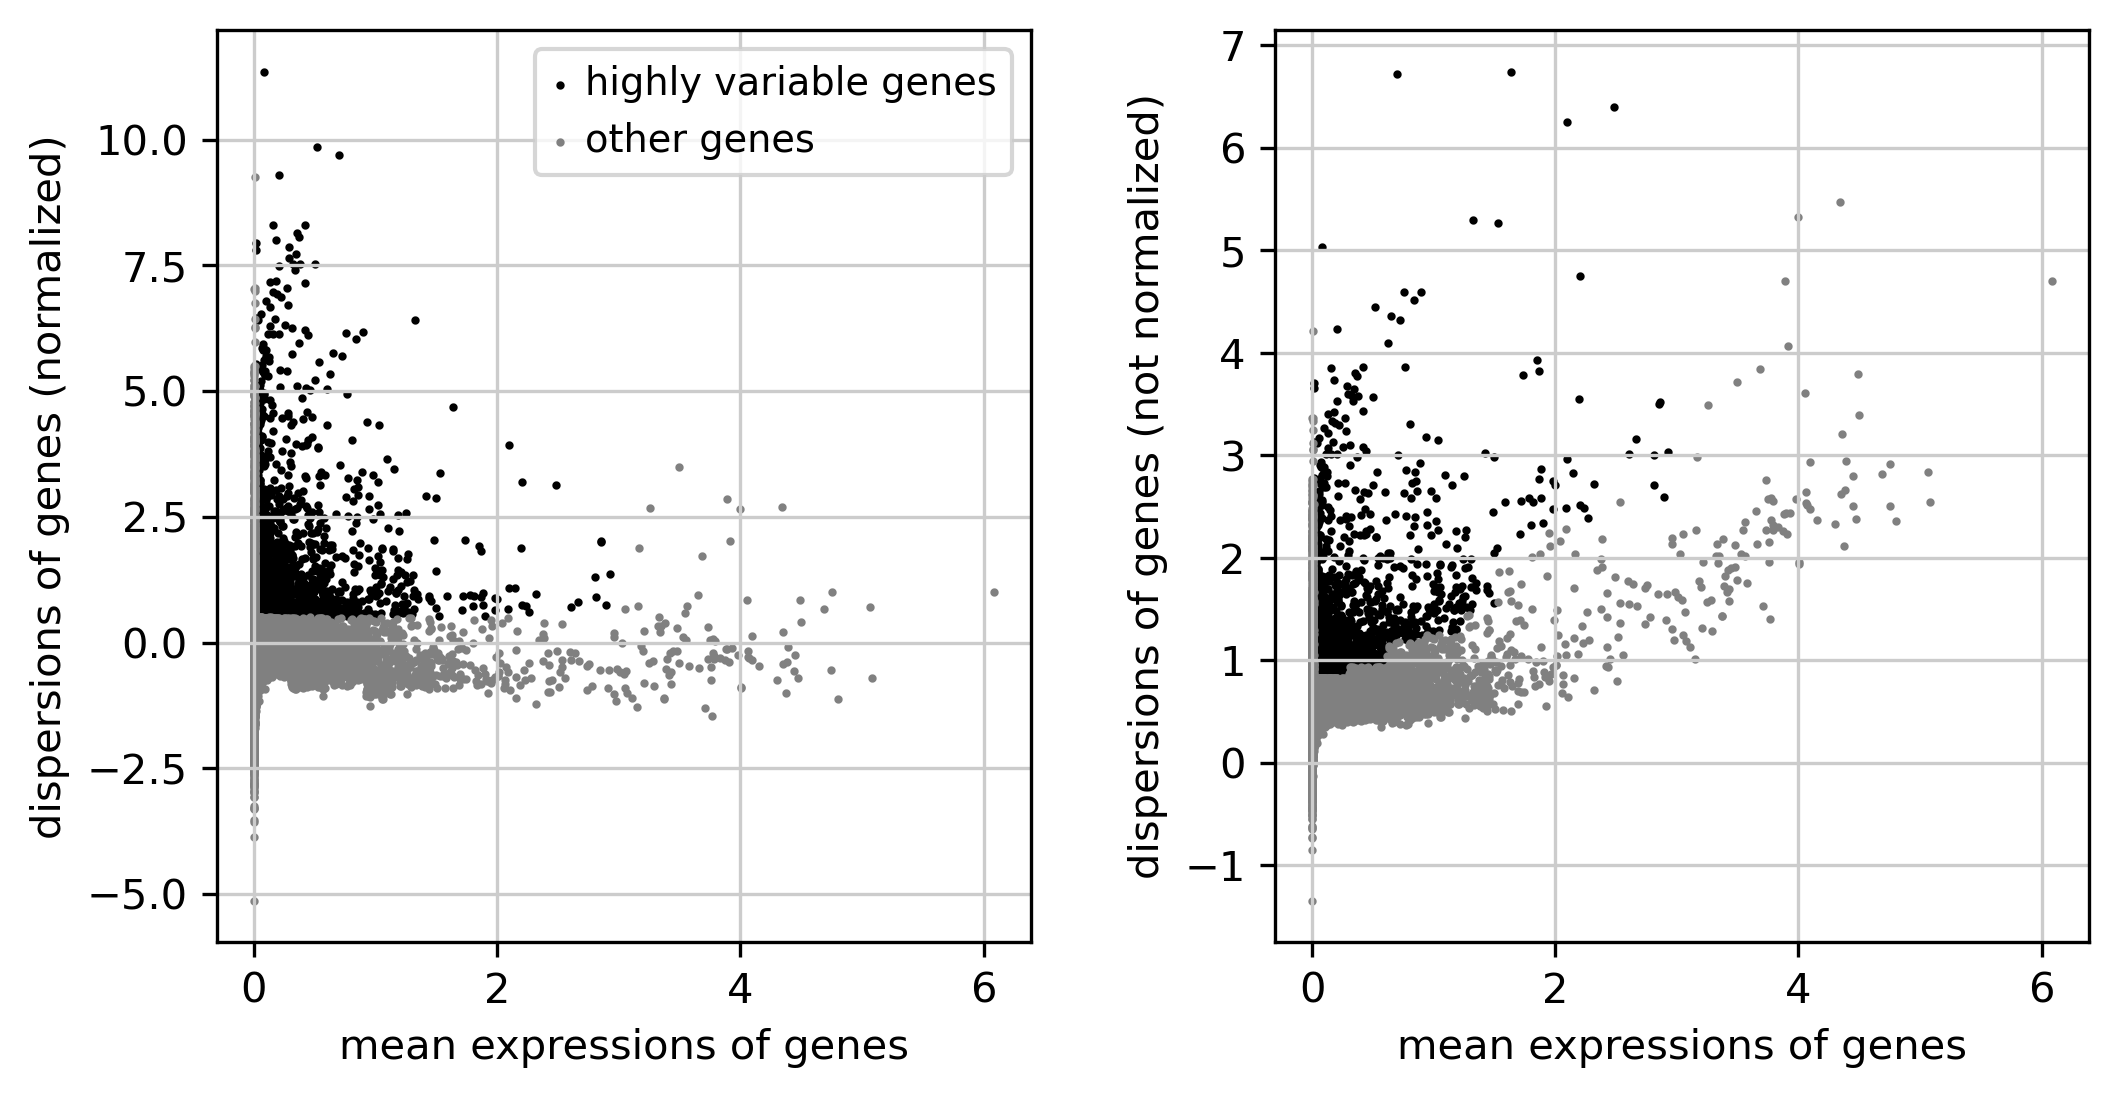

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:31)


In [48]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path_integrated )

### 1 PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


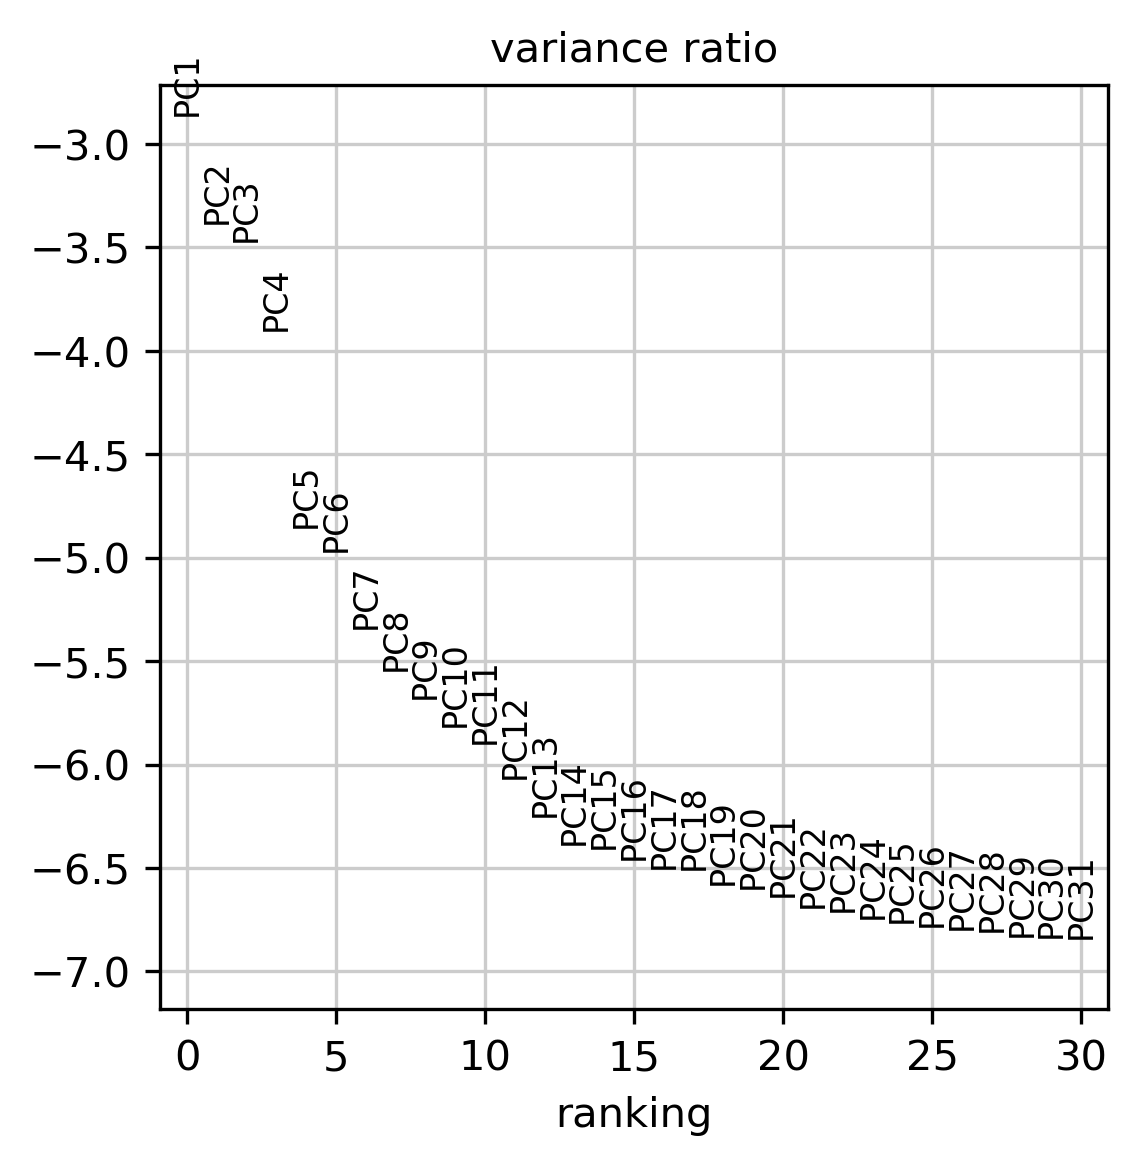

In [49]:
# adata = sc.read_h5ad( f_anndata_path_integrated )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path_integrated )

### 1b PCA component selection

In [ ]:
# TODO

### 2 Visualization of highly variable genes

In [50]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=7 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path_integrated )

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:50)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


### 3 Clustering

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


/opt/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


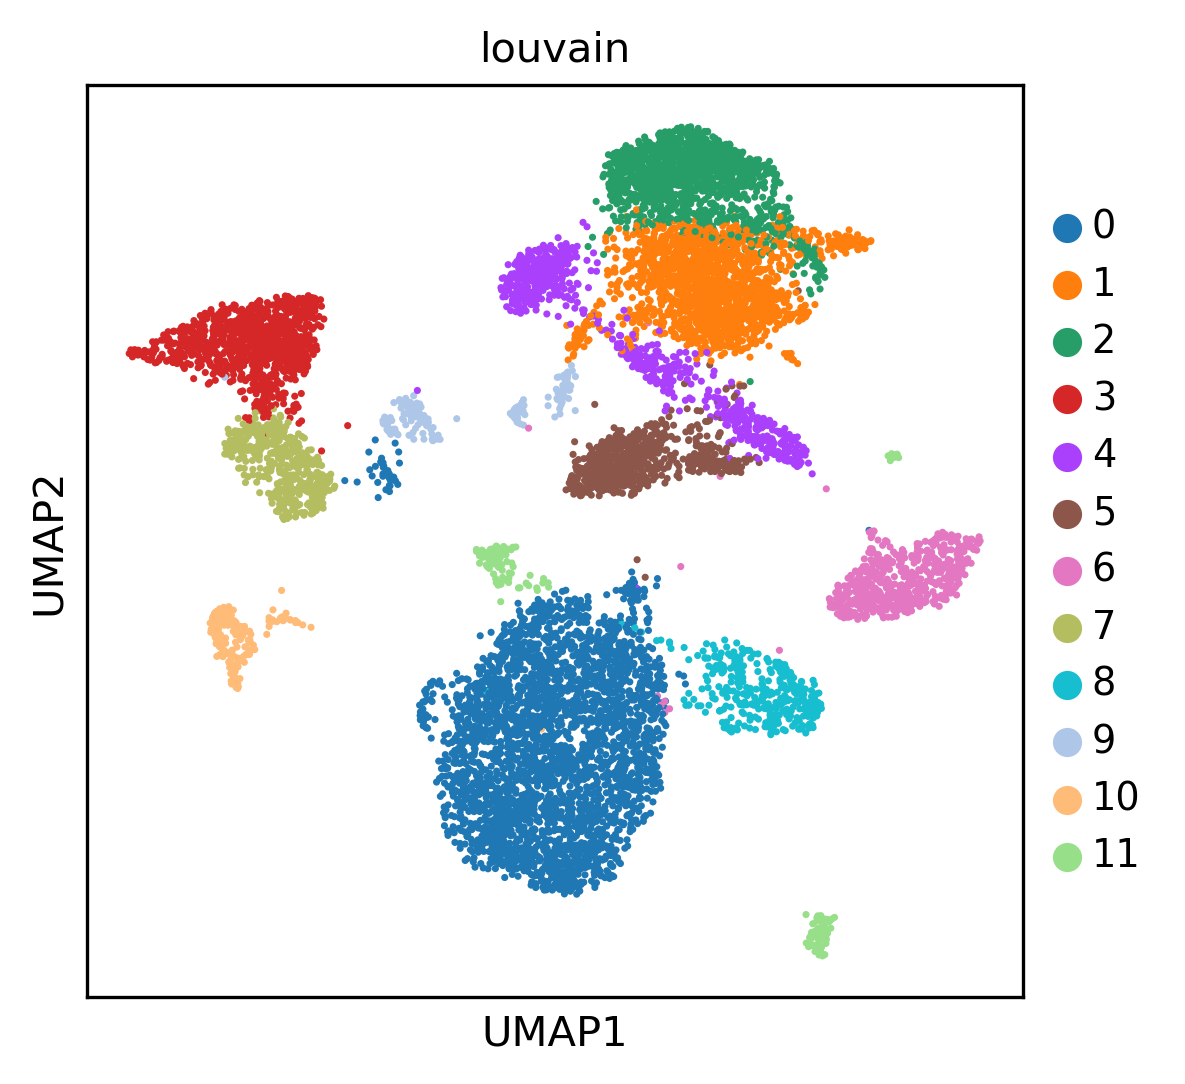

In [51]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


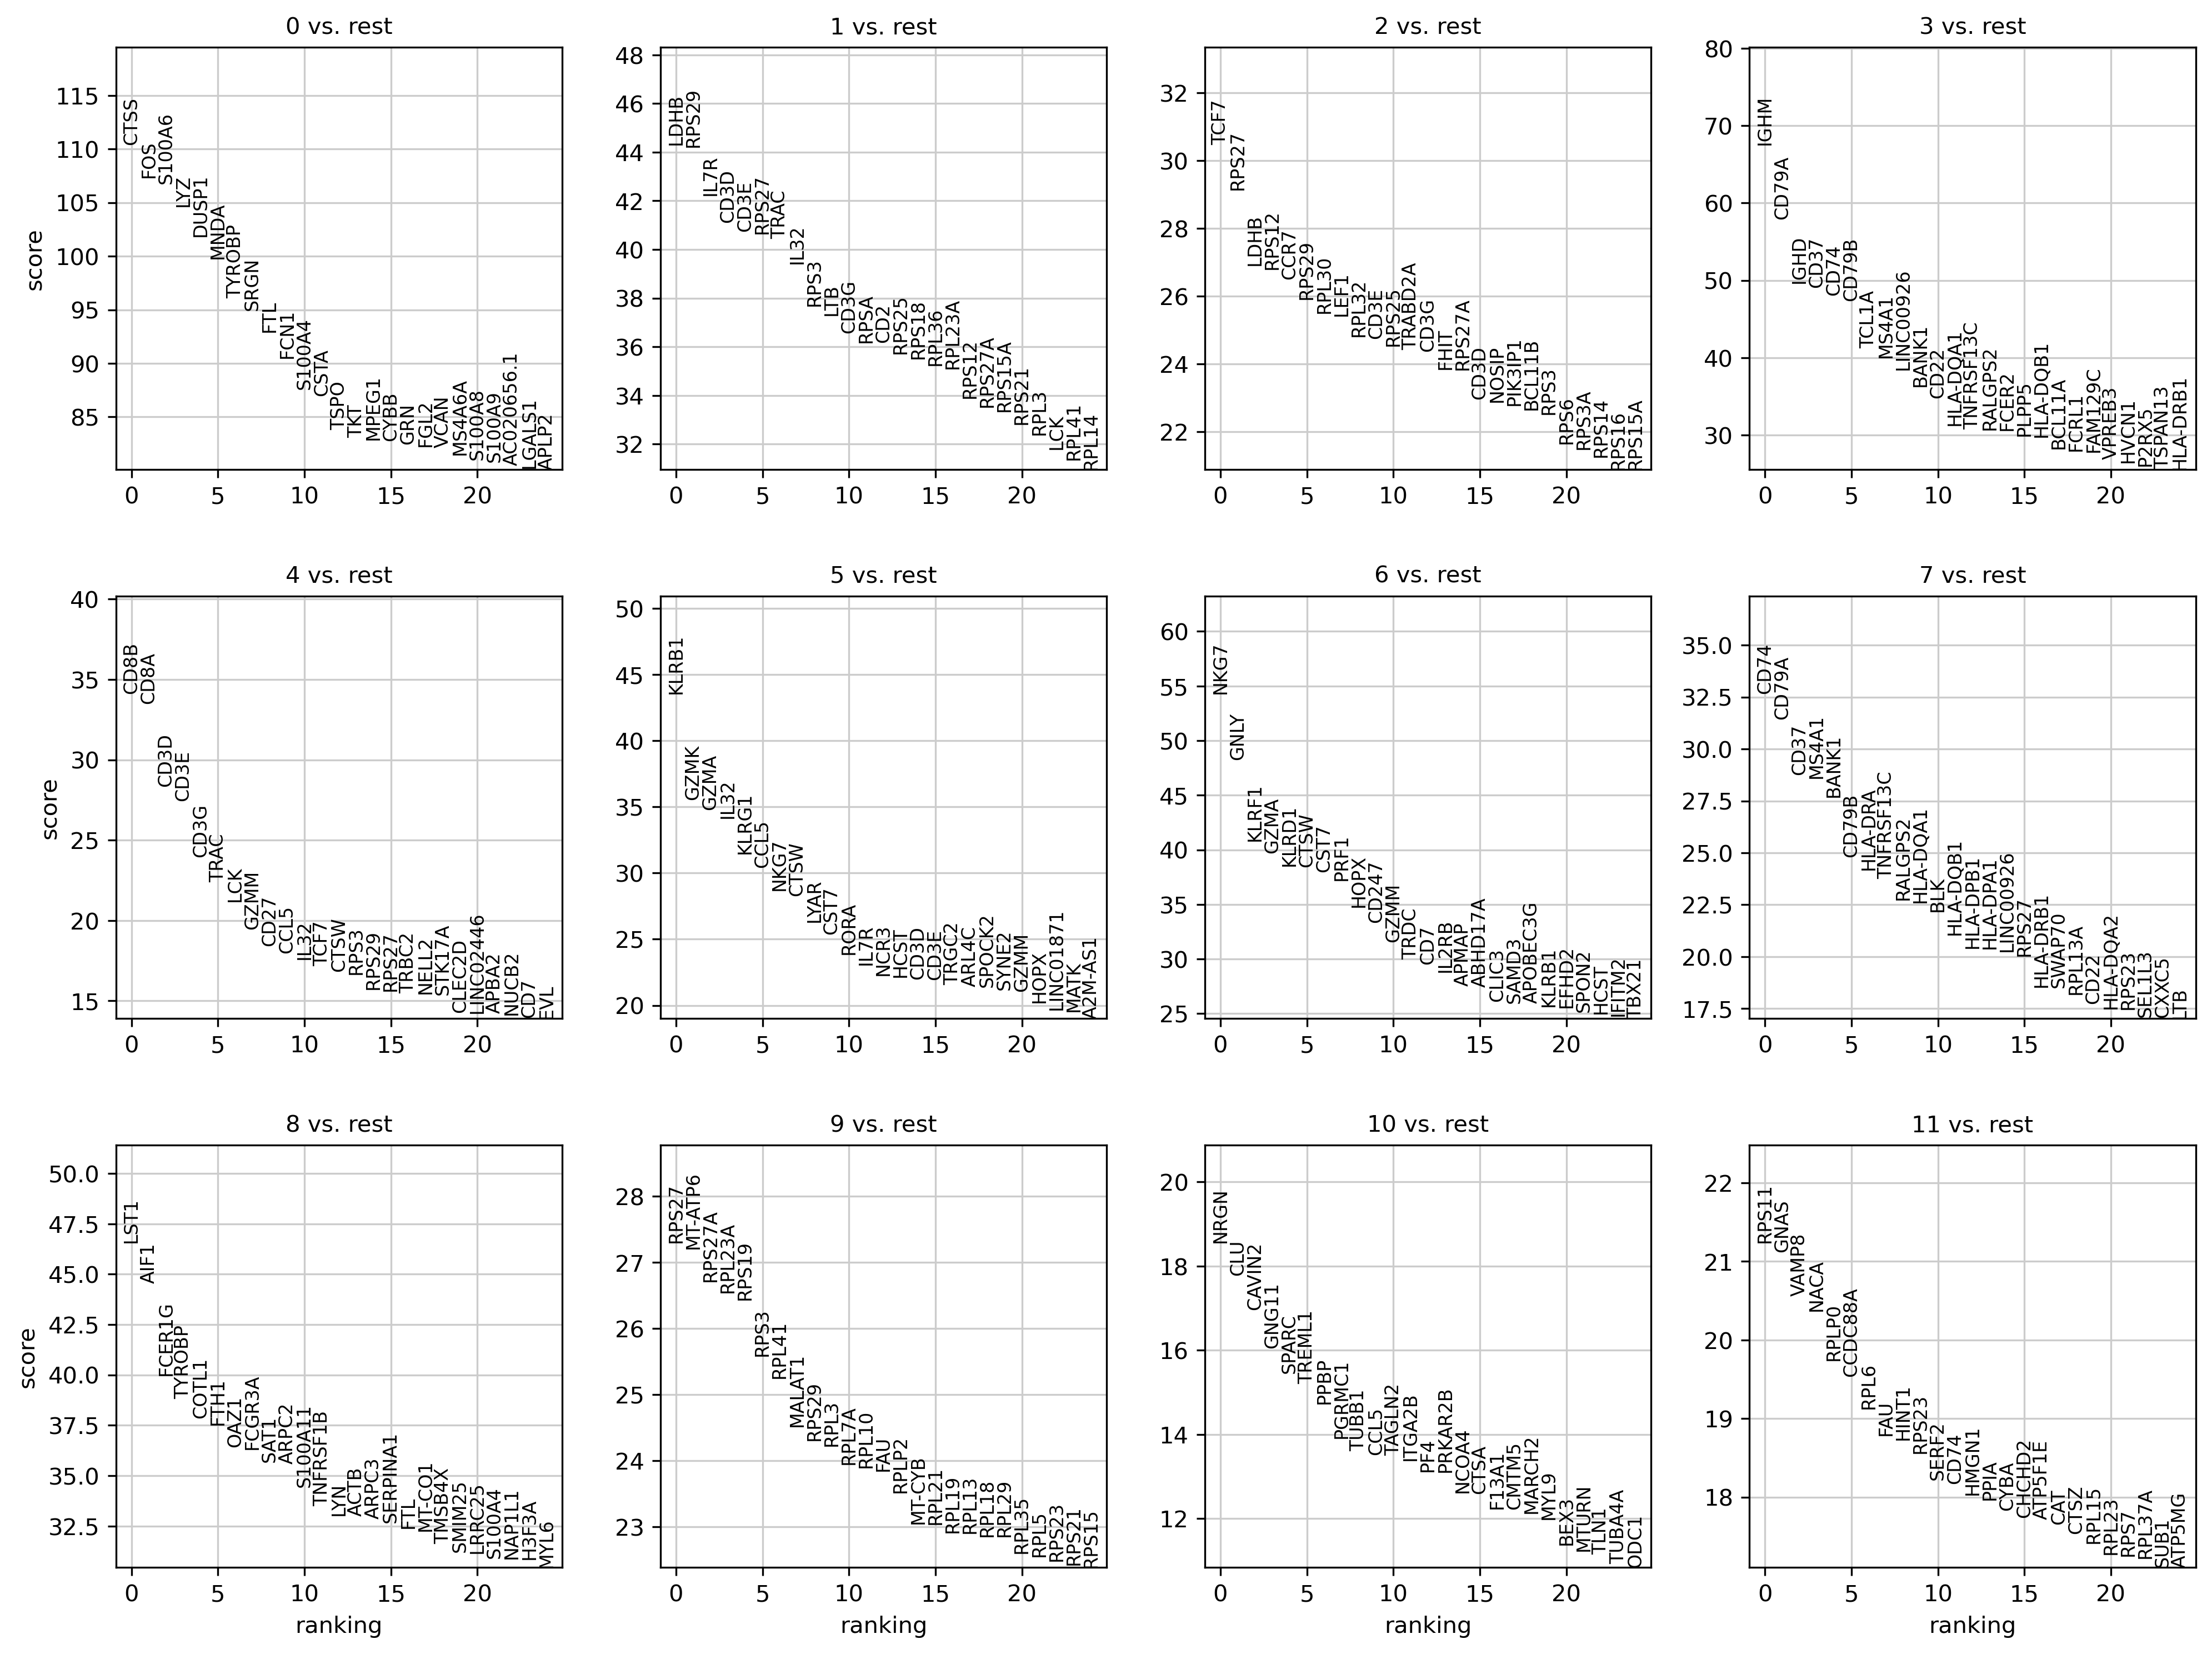

In [52]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path_integrated )

## 6. SCENIC steps

### STEP 1: Gene regulatory network inference, and generation of co-expression modules

#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [8]:
#Load tf names
from arboreto.utils import load_tf_names
tf_names = load_tf_names(f_tfs)

In [9]:
#Getting TF list length
len(tf_names)

1839

In [10]:
from datetime import datetime
currentDateAndTime = datetime.now()
currentDateAndTime = currentDateAndTime.strftime("%Y_%m_%d_%H-%M-%S")
print(currentDateAndTime)

2023_03_14_18-45-50


In [11]:
#Start date 
!date -u +"%c"

Tue 14 Mar 2023 06:45:51 PM UTC


In [ ]:
### CLI version
!pyscenic grn \
--seed 40 \
-o {f_adj_csv} \
--client_or_address {dask_scheduler_name} \
{f_loom_path_scenic} \
{f_tfs}


2023-03-14 18:46:01,217 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-03-14 18:46:07,006 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph


In [13]:
#end date 
!date -u +"%c"

Wed 15 Mar 2023 10:00:03 AM UTC


#### Alternative: Using arboreto GRNboost2 version
**Note: You can start from here if a filtered expression matrix dataframe is available**

##### i. Converting matrix numpy strings top python strings
**Only necessary if they are not already python strings**

In [ ]:
#Check matrix
type(ex_matrix_int.columns[0])

In [ ]:
#Changing dataframe column name data type
ex_matrix_int.columns = ex_matrix_int.columns.astype(str)

In [ ]:
#Checking it worked
type(ex_matrix_int.columns[0])

**Saving the matrix dataframes again**

In [ ]:
#Saving corrected adjacencies to file
adj.to_pickle(f_adj_pickle)

In [ ]:
ex_matrix_int.to_pickle(ex_matrix_path_final)

##### ii. Continuing to run GRNboost2

In [ ]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

In [ ]:
#Loading the final int64_matrix as a pickle
ex_matrix_int = pd.read_pickle(ex_matrix_path_final)

In [ ]:
#Checking matrix
ex_matrix_int.head()

In [ ]:
#Matrix shape
ex_matrix_int.shape

In [ ]:
# transcription factors list
 f_tfs = "/home/jovyan/work/dask_k8s/PBMC_project/work_dir/input/hs_hgnc_tfs.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [ ]:
#Load tf names
tf_names = load_tf_names(f_tfs)

In [ ]:
#Getting TF list length
len(tf_names)

##### Timestamp

In [ ]:
from datetime import datetime
currentDateAndTime = datetime.now()
currentDateAndTime = currentDateAndTime.strftime("%Y_%m_%d_%H-%M-%S")
print(currentDateAndTime)

In [ ]:
#Start date 
!date -u +"%c"

In [ ]:
#Start date Unix
!date +"%s"

##### GRNboost2

In [ ]:
#Checking the client access is present
c

In [ ]:
### GRNboost2 version
if __name__ == '__main__':
    from dask.distributed import performance_report
    with performance_report(filename="stress_testing/dask-report_%s.html"%(currentDateAndTime)):
       adjacencies = grnboost2(ex_matrix_int, tf_names=tf_names, verbose=True, client_or_address=c)

In [ ]:
#end date 
!date -u +"%c"

##### Checking adjacencies

In [ ]:
#Checking the adjacencies matrix
adjacencies.head()

In [ ]:
#Checking adjacencies shape
adjacencies.shape

In [ ]:
#Saving adjacencies to pickle
adjacencies.to_pickle(f_adj_pickle)

In [ ]:
#Checking adjacencies file size
adjacencies.info(memory_usage="deep")

read in the adjacencies matrix:

### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

#### CLI version

locations for ranking databases, and motif annotations:

In [8]:
import glob
# extracting ranking database list
f_db_names = ' '.join( glob.glob(DATABASES_GLOB) )

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

In [15]:
!pyscenic ctx {f_adj_csv} \
    {f_db_names} \
    --annotations_fname {MOTIF_ANNOTATIONS_FNAME} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output {f_motifs_csv} \
    --mask_dropouts \
    --mode "dask_cluster" \
    --client_or_address {dask_scheduler_IP}


2023-03-15 10:45:19,324 - pyscenic.cli.pyscenic - INFO - Creating modules.

2023-03-15 10:45:22,915 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-03-15 10:45:28,470 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-03-15 10:45:30,401 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2023-03-15 10:47:19,518 - pyscenic.utils - INFO - Creating modules.

2023-03-15 10:51:10,826 - pyscenic.cli.pyscenic - IN

#### Alternative: Jupyter version

In [ ]:
#Retrieve libraries
import glob

from dask.diagnostics import ProgressBar

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons

##### 1. Recovering previous files

In [ ]:
#Loading the final int64_matrix as a pickle
ex_matrix_int = pd.read_pickle(ex_matrix_path_final)

In [ ]:
#Checking shape
ex_matrix_int.shape

In [ ]:
#Re-loading the adjacencies dataframe
#adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')
adj = pd.read_pickle(f_adj_pickle).reset_index(drop=True)

In [ ]:
#Checking adjacencies
adj.head()

In [ ]:
#Finding datatypes (check that python strings are used)
adj.info()

In [ ]:
#What is the object data type? (check that python strings are used)
type(adj.loc[0,"TF"])

##### 2. Obtaining the modules

In [ ]:
#Obtaining module list
modules = list(modules_from_adjacencies(adj, ex_matrix_int))

In [ ]:
#Checking object type
type(modules)

In [ ]:
#Checking a module
modules[0:1]

In [ ]:
#Saving the module to a file
def write_modules(md, path):
    # store list in binary file so 'wb' mode
    with open(path, 'wb') as fh:
        pk.dump(md, fh)
        print('Done writing list into a binary file')

write_modules(modules, f_modules_output)

##### 2. Retrieving the feather database

In [ ]:
#Retrieving the databases path
DATABASE_FOLDER = os.environ['DATABASES_PATH']
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "PBMC/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather")

In [ ]:
DATABASES_GLOB

In [ ]:
#Loading ranking databases
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

In [ ]:
dbs[0]

##### 3. Retrieving modules

In [ ]:
#Retrieving modules
def read_modules(path):
    # accessing the same file
    with open(path, 'rb') as fh:
        n_list = pk.load(fh)
        return n_list

modules = read_modules(f_modules_output)

##### 4. Getting timestamp

In [ ]:
from datetime import datetime
currentDateAndTime = datetime.now()
currentDateAndTime = currentDateAndTime.strftime("%Y_%m_%d_%H-%M-%S")
print(currentDateAndTime)

In [ ]:
#Start date 
!date -u +"%c"

##### 5. Running prune2df

In [ ]:
from dask.distributed import performance_report
with performance_report(filename="stress_testing/prune2df/dask-report_%s.html"%(currentDateAndTime)):
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME, client_or_address=c)
df.shape

In [ ]:
#Checking dataframe
df.head()

##### 4. Getting regulons and saving to file

In [ ]:
#Saving motifs to file
df.to_csv(f_motifs_csv)

In [ ]:
#Obtaining regulons
regulons = df2regulons(df)

In [ ]:
#Checking a regulon
regulons[0:1]

In [ ]:
#Saving regulons
with open(f_regulons_pickle, "wb") as f:
    pk.dump(regulons, f)

### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC.
The following histogram gives an idea of the distribution and allows selection of an appropriate threshold.
In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses).
See [the relevant section in the R tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html#build-gene-expression-rankings-for-each-cell) for more information.

By using the default setting for `--auc_threshold` of `0.05`, we see that **1192** genes are selected for the rankings based on the plot below.

#### 1. Previous analysis and CLI AUCell

In [ ]:
nGenesDetectedPerCellbefore = np.ravel(np.sum(adata.X>0, axis=1))
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

Input files:
1. The filtered expression matrix (loom version of ex_matrix_int)
2. The enriched motif dataframe

In [ ]:
!pyscenic aucell \
{f_loom_path_scenic} \
{f_motifs_csv} \
--output {f_pyscenic_output} \
--num_workers 7

#### 2. Loading files again

In [ ]:
#Loading the expression matrix
ex_matrix_int = pd.read_pickle(ex_matrix_path_final)

In [ ]:
#Loading the regulons
with open(f_regulons_pickle, 'rb') as fh:
    regulons = pk.load(fh)

In [ ]:
type(regulons[0])

#### 3. Jupyter AUCell version

In [ ]:
from pyscenic.aucell import aucell

In [ ]:
#Running AUCell
auc_mtx = aucell(ex_matrix_int, regulons, num_workers=7)

In [ ]:
type(auc_mtx)

In [ ]:
#Assessing shape
auc_mtx.shape

In [ ]:
auc_mtx.head()

In [ ]:
#Saving to csv
auc_mtx.to_csv(f_auccell_mtx_csv)

In [ ]:
#Saving to pickle
auc_mtx.to_pickle(f_auccell_mtx_pickle)

#### 4. Plotting

In [ ]:
#Re-loading auc_mtx
auc_mtx = pd.read_pickle(f_auccell_mtx_pickle)
auc_mtx.head()

In [ ]:
#Getting final plot
plot = sns.clustermap(auc_mtx, figsize=(8,8))

In [ ]:
plot.savefig(f_aucell_cluster)

### Visualization of SCENIC's AUC matrix

#### First, load the relevant data from the loom we just created 
**(this step can be skipped if the non-CLI version was used).**

In [ ]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

#### Visualization steps

In [ ]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=7 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

## 7. Integrate the output

Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file

In [ ]:
#Recovering the adata file
adata = sc.read_h5ad( f_anndata_path )

In [ ]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

Fix regulon objects to display properly in SCope:

In [ ]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

Concatenate embeddings (tSNE, UMAP, etc.)

In [ ]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

Metadata:

In [ ]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

Assemble loom file row and column attributes

In [ ]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [ ]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

Create a new loom file, copying the expression matrix from the open loom connection:

In [ ]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

This loom file can now be imported into [SCope](http://scope.aertslab.org/).